Initial explanation about the project.

Since our dataset is already preprocessed we can just simply import the desired tools and load the data.

In [15]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn as skl
import matplotlib.pyplot as plt

dataframe = pd.read_csv('data.csv')
#dataframe.head()

Now we set our X and Y axis.

In [16]:
x_axis = dataframe.drop('Target', axis=1)
y_axis = dataframe['Target']

Now we split our data between training and testing.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_axis, y_axis, test_size=0.25, random_state=40)

The next step is to train our model.

In [ ]:
start_train = time.time()
clf = DecisionTreeClassifier(random_state=40)
clf.fit(x_train, y_train)
end_train = time.time()

We test our Decision Tree with the X axis test data.

In [19]:
start_test = time.time()
y_pred = clf.predict(x_test)
end_test = time.time()

Finally we check wether our Decision Tree was sucessful or not and categorize it in several metrics.

In [20]:
accuracy = skl.metrics.accuracy_score(y_test, y_pred)
precision = skl.metrics.precision_score(y_test, y_pred, average="weighted", zero_division=0)
recal = skl.metrics.recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_score = skl.metrics.f1_score(y_test, y_pred, average="weighted", zero_division=0)
confusion_matrix = skl.metrics.confusion_matrix(y_test,y_pred)


print(f"Acuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recal:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print("Confusion Matrix:\n")
print(confusion_matrix)
print("Classification Report:\n")
print(skl.metrics.classification_report(y_test,y_pred, zero_division=0))

print(f"Training time: {end_train-start_train:.4f} seconds")
print(f"Testing time: {end_test-start_test:.4f} seconds")



Acuracy: 0.6646
Precision: 0.6575
Recall: 0.6646
F1-Score: 0.6607
Confusion Matrix:

[[250  62  53]
 [ 59  75  83]
 [ 55  59 410]]
Classification Report:

              precision    recall  f1-score   support

     Dropout       0.69      0.68      0.69       365
    Enrolled       0.38      0.35      0.36       217
    Graduate       0.75      0.78      0.77       524

    accuracy                           0.66      1106
   macro avg       0.61      0.60      0.61      1106
weighted avg       0.66      0.66      0.66      1106

Training time: 0.0522 seconds
Testing time: 0.0034 seconds


Here's the visual representation of the Decision Tree.

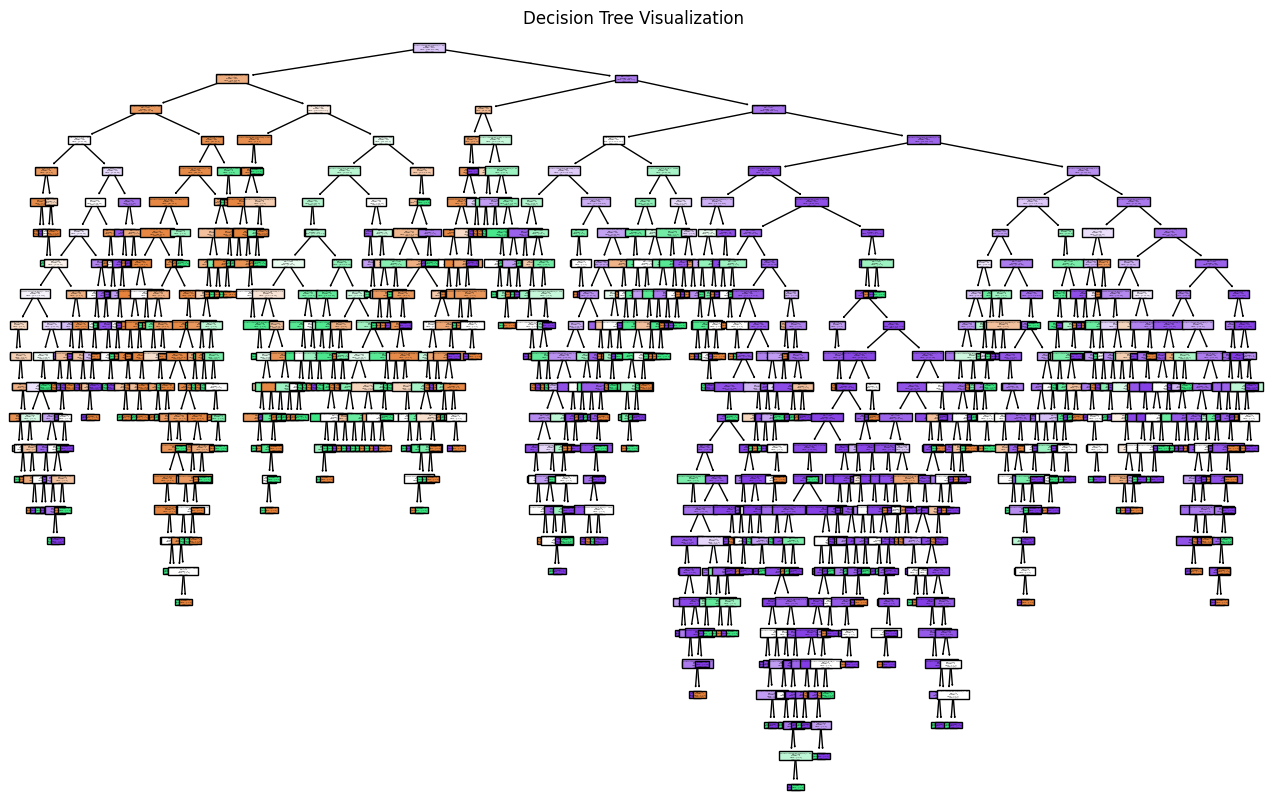

In [21]:
plt.figure(figsize=(16,10))
skl.tree.plot_tree(clf, filled=True, feature_names=x_axis.columns, class_names=True)
plt.title("Decision Tree Visualization")
plt.show()